Imports

In [1]:
%matplotlib inline
import torch
from tqdm.notebook import tqdm as tqdm
import os
import pandas as pd
import matplotlib.pyplot as plt
import hashlib

from HGNN.train.configParser import ConfigParser
from myhelpers import config_plots, TrialStatistics
from HGNN.train import CNN, dataLoader
config_plots.global_settings()

experimetnsFileName = "experiments.csv"

Parameters

In [2]:
experimentsPath="/raid/elhamod/Fish/experiments/"
dataPath="/raid/elhamod/Fish/"

sub_output_path = 'biologypaper/lowalpha/lambda_comparisons'


experiment_list = [
    {
       'experimentName': "biology_paper_curated4_Medium_lowalpha",
       'trial_hash': 'fe92041f4795ea893a098591d337fdfaaecfbdac66e32df0394f6213',
       'label': "$\mathbf{HGNN-lambda01}$"
    },
    {
       'experimentName': "biology_paper_curated4_Medium_lowalpha",
       'trial_hash': '05b0b421ea73e86acaa7c53494c2fa833e0bcb740829377522db1d72',
       'label': "$\mathbf{HGNN-lambda001}$"
    },
]

first_n_epochs = None # None means all.


cuda=6

plotsToDisplay= [{
    'validation_fine_f1': {"label":"validation" ,"secondary":False},
#     'validation_loss': {"label":"validation loss","secondary":True},
#     'training_fine_f1': {"label":"training" ,"secondary":False},
    'test_fine_f1': {"label":"test f1" ,"secondary":False},
#     'validation_coarse_f1': {"label":"test coarse f1" ,"secondary":False},
#     'training_loss': {"label":"training loss","secondary":True}
}]

Cuda

In [3]:
# set cuda
if torch.cuda.is_available():
    torch.cuda.set_device(cuda)
    print("using cuda", cuda)

using cuda 6


Get experiment parameters and model

In [4]:
# Get experiment parameters
dfs = []
labels=[]
for trial in experiment_list:
    experimentName=trial['experimentName']
    trial_hash=trial['trial_hash']
    labels.append(trial['label'])

    experimentsFileNameAndPath = os.path.join(experimentsPath, experimetnsFileName)
    if os.path.exists(experimentsFileNameAndPath):
        experiments_df = pd.read_csv(experimentsFileNameAndPath)
    else:
        raise Exception("Experiment not " + trial_hash + " found!")
    experimentRecord = experiments_df[experiments_df["trialHash"] == trial_hash]
    experiment_params = experimentRecord.to_dict('records')[0]
    print(experiment_params)

    experimentPathAndName = os.path.join(experimentsPath, experimentName)

    # get the model and the parameters
    modelName = experimentRecord.iloc[0]["modelName"]
    trialName = os.path.join(experimentPathAndName, modelName)

    # get stats
    df = pd.read_csv(os.path.join(trialName, 'stats.csv'))
    if first_n_epochs is not None:
        df = df.head(first_n_epochs)
    dfs.append(df)

{'experimentName': 'biology_paper_curated4_Medium_lowalpha', 'modelName': 'models/fe92041f4795ea893a098591d337fdfaaecfbdac66e32df0394f6213', 'datasetName': 'datasplits/4011b5599510cfa7885cd68683d6897854313f821e76f307220d8526', 'experimentHash': 'd1ff39fe45d9391850c1e5fd3dfe6225359f78420886666ddd2af5d3', 'trialHash': 'fe92041f4795ea893a098591d337fdfaaecfbdac66e32df0394f6213', 'image_path': 'Curated4/Medium', 'suffix': 'curated_30_50', 'img_res': 448, 'augmented': True, 'batchSize': 100, 'learning_rate': 0.0001, 'numOfTrials': 1, 'fc_layers': 1, 'modelType': 'HGNN_add', 'lambda': 0.01, 'unsupervisedOnTest': False, 'tl_model': 'ResNet18', 'link_layer': 'avgpool', 'adaptive_smoothing': True, 'adaptive_lambda': 0.01, 'adaptive_alpha': 0.1}
{'experimentName': 'biology_paper_curated4_Medium_lowalpha', 'modelName': 'models/05b0b421ea73e86acaa7c53494c2fa833e0bcb740829377522db1d72', 'datasetName': 'datasplits/4011b5599510cfa7885cd68683d6897854313f821e76f307220d8526', 'experimentHash': '5533e8f5c

Plot progress

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


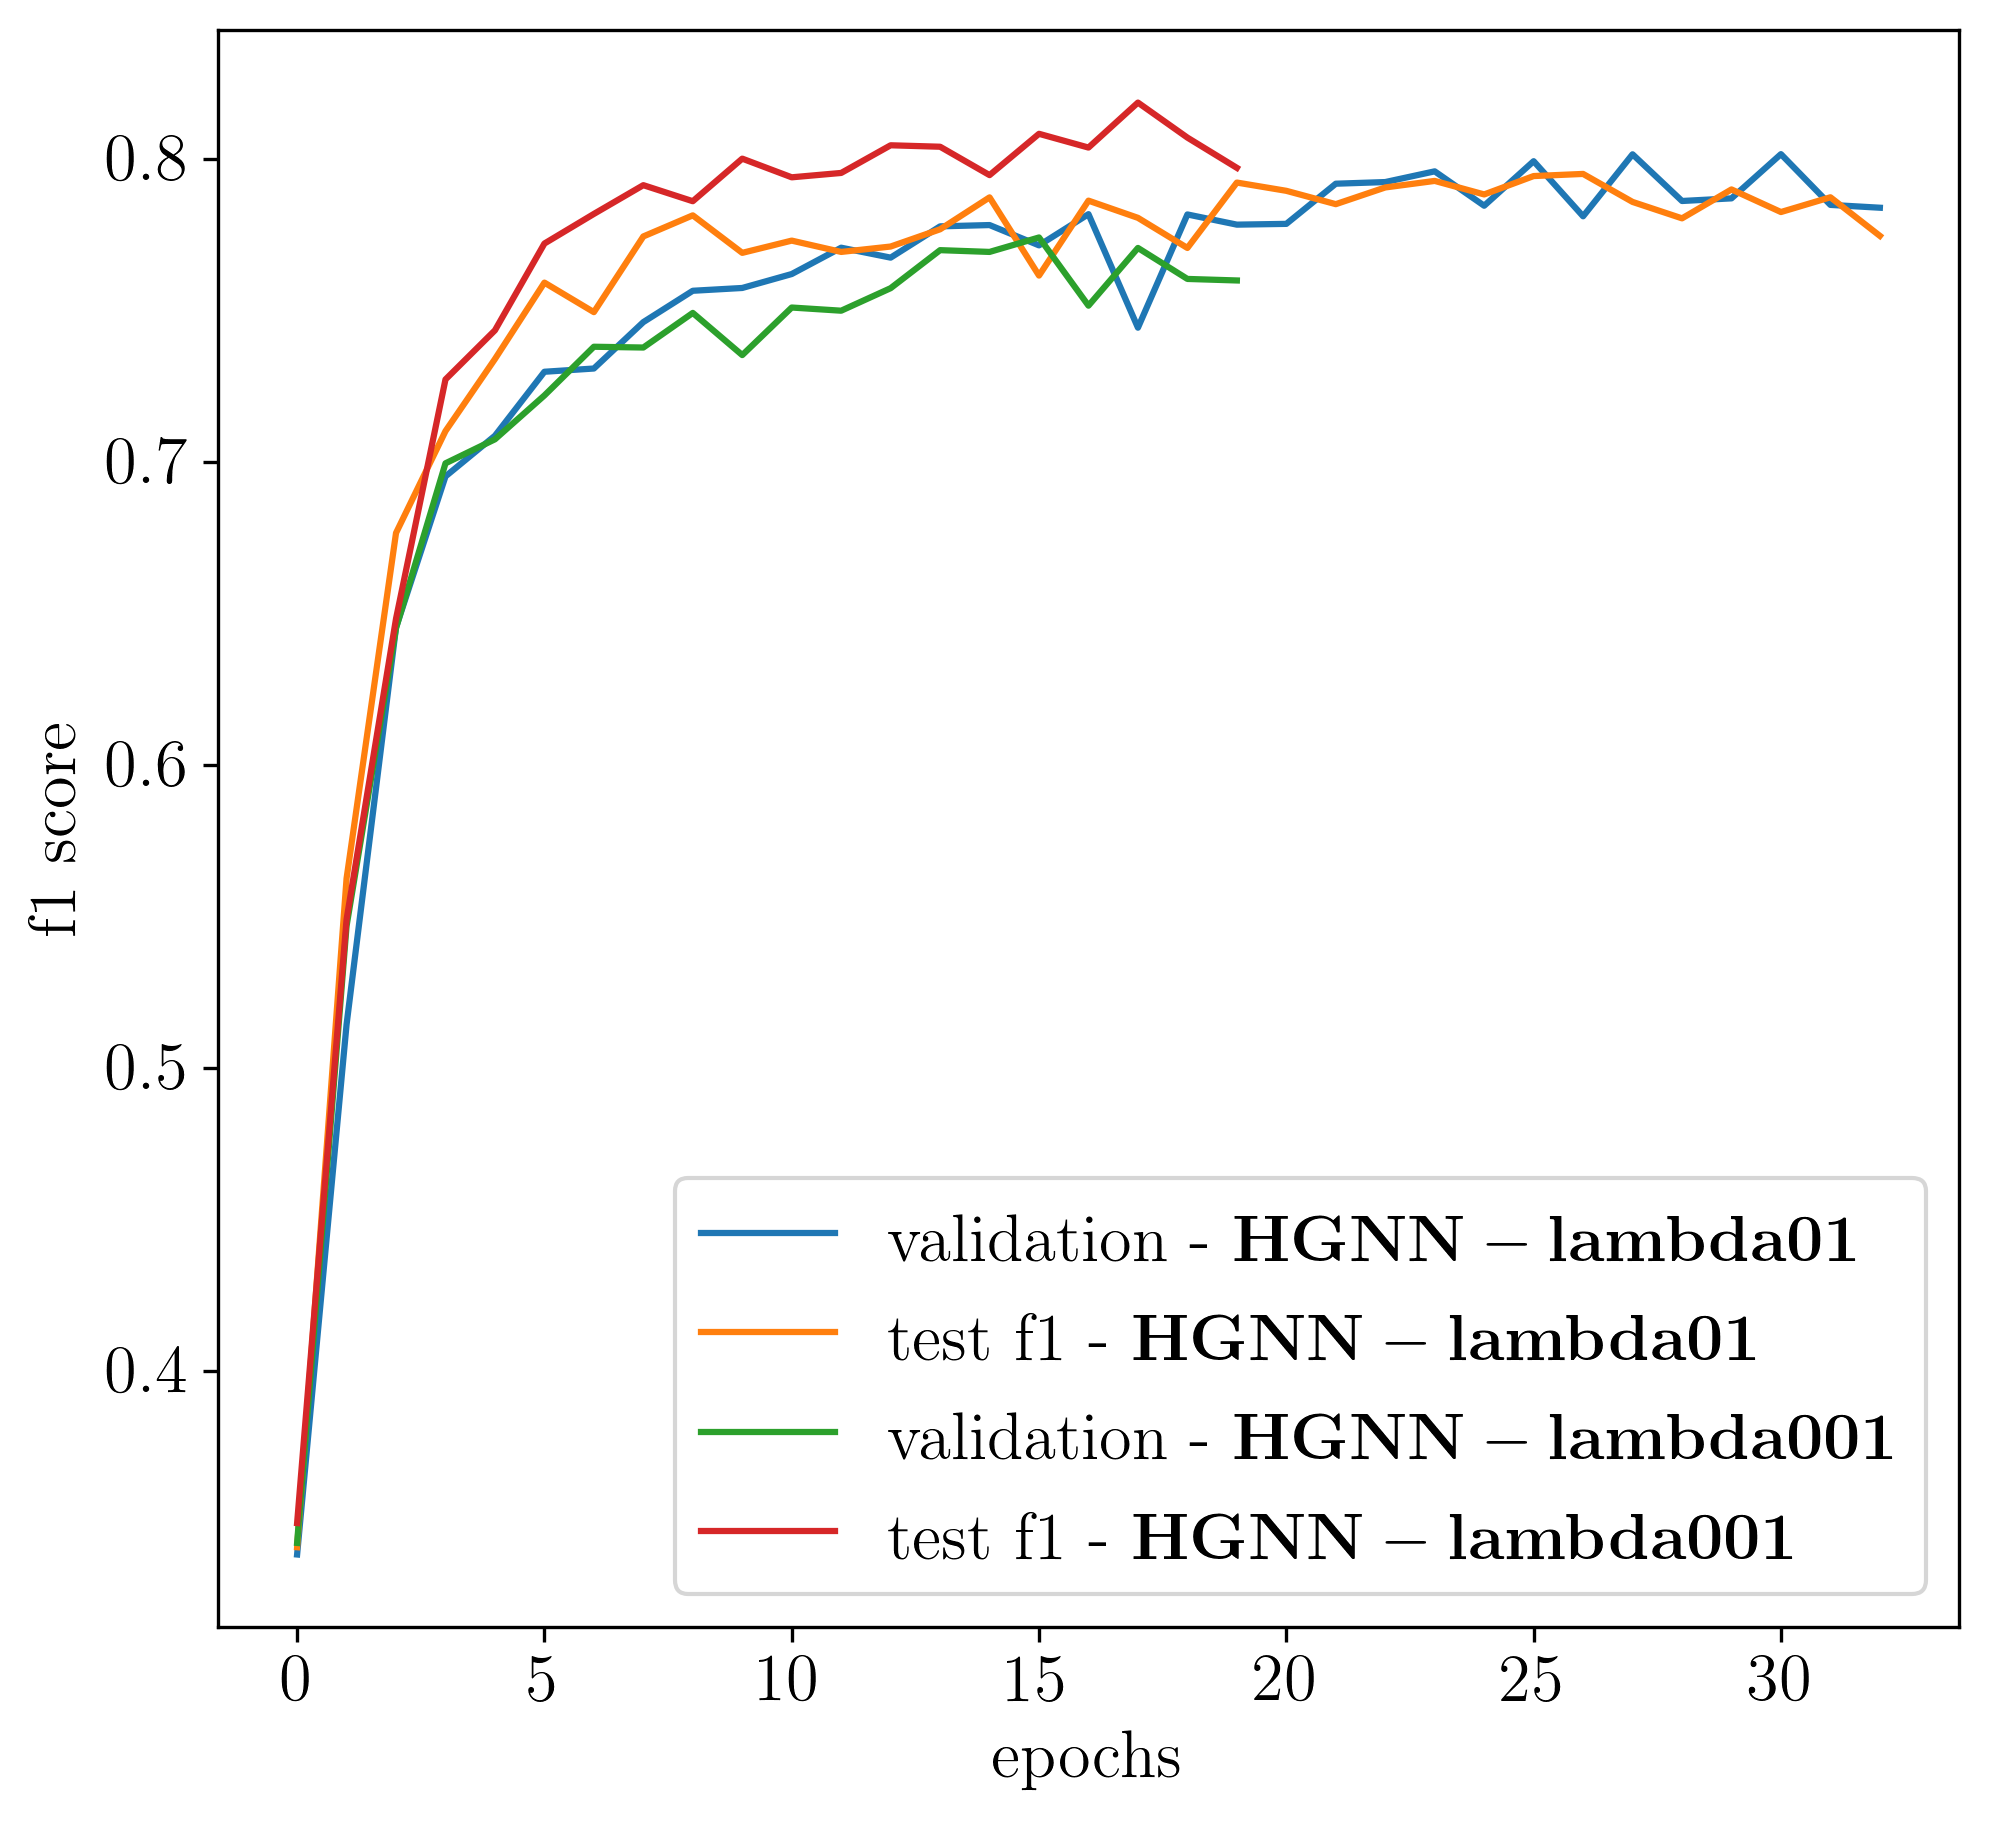

In [5]:
fig,ax = plt.subplots(figsize=(7, 7))
for i, df in enumerate(dfs):
    trial_label = labels[i]
    for plotToDisplay in plotsToDisplay:

        for key in plotToDisplay:
            df = df.rename(columns={key: " - ".join([plotToDisplay[key]['label'], trial_label])})


        y_primary=[]
        y_secondary=[]
        for key in plotToDisplay:
            if plotToDisplay[key]["secondary"]:
                y_secondary.append(key) # 
            else:
                y_primary.append(key)

        y_primary_labels = list(map(lambda x: " - ".join([plotToDisplay[x]["label"], trial_label]), y_primary))
        y_secondary_labels = list(map(lambda x:  " - ".join([plotToDisplay[x]["label"], trial_label]), y_secondary))
        y_primary_labels2 = list(map(lambda x: plotToDisplay[x]["label"], y_primary))
        y_secondary_labels2 = list(map(lambda x:  plotToDisplay[x]["label"], y_secondary))
        df_cleaned = df[(y_secondary_labels + y_primary_labels)]

        lines = []
        if len(y_primary_labels) > 0:
            df_cleaned.plot(ax=ax, y=y_primary_labels)
#             ax.set_ylabel(str(y_primary_labels2))
            lines = ax.get_lines()
        if len(y_secondary_labels) > 0:
            df_cleaned.plot(ax=ax, y=y_secondary_labels, secondary_y=True)
#             ax.right_ax.set_ylabel(str(y_secondary_labels2))
            lines = lines+ ax.right_ax.get_lines()

        ax.legend(lines, [l.get_label() for l in lines], loc='lower right')
        
ax.set_ylabel('f1 score')
ax.set_xlabel('epochs')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
path=  os.path.join(experimentsPath, 'figures', sub_output_path, 'convergence')
if not os.path.exists(path):
    os.makedirs(path)
fig.savefig(os.path.join(path, 'training_plot_'+hashlib.sha224(str(plotsToDisplay).encode('utf-8')).hexdigest()+'.pdf'), bbox_inches='tight')